In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [3]:
DataTransforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.25,0.25,0.25])
    ]),
    'val' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.25,0.25,0.25])
    ])
}

In [9]:
Data = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(Data, x), DataTransforms[x]) for x in ['train', 'val']}
data_loaders = {x : DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [13]:
dataset_sizes  = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'dataset_sizes: {dataset_sizes}, class_names: {class_names}')

dataset_sizes: {'train': 244, 'val': 153}, class_names: ['ants', 'bees']


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].


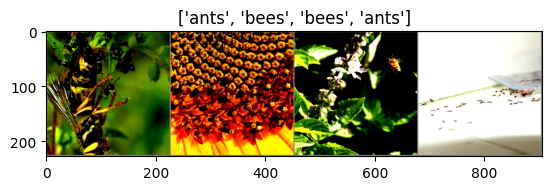

In [17]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.show()
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def model_trainer(model, criterion, optimizer, scheduler, num_epochs=15):
    
    t = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        time_elapsed = time.time() - t
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model


In [22]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

step_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model_trainer(model, criterion, optimizer, step_lr, num_epochs=20)

c:\Users\ambakuma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ambakuma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ambakuma/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.34MB/s]


Epoch 0/19
----------
train Loss: 0.6535 Acc: 0.6270
val Loss: 0.5407 Acc: 0.7582
Training complete in 0m 49s
Best val Acc: 0.7582
Epoch 1/19
----------
train Loss: 0.5935 Acc: 0.7172
val Loss: 0.4430 Acc: 0.8105
Training complete in 1m 40s
Best val Acc: 0.8105
Epoch 2/19
----------
train Loss: 0.4570 Acc: 0.8115
val Loss: 0.3234 Acc: 0.9085
Training complete in 2m 31s
Best val Acc: 0.9085
Epoch 3/19
----------
train Loss: 0.3610 Acc: 0.8730
val Loss: 0.3372 Acc: 0.8627
Training complete in 3m 22s
Best val Acc: 0.9085
Epoch 4/19
----------
train Loss: 0.4525 Acc: 0.7623
val Loss: 0.2751 Acc: 0.9150
Training complete in 4m 15s
Best val Acc: 0.9150
Epoch 5/19
----------
train Loss: 0.4107 Acc: 0.8361
val Loss: 0.2701 Acc: 0.9281
Training complete in 5m 20s
Best val Acc: 0.9281
Epoch 6/19
----------
train Loss: 0.3764 Acc: 0.8074
val Loss: 0.2802 Acc: 0.9150
Training complete in 6m 41s
Best val Acc: 0.9281
Epoch 7/19
----------
train Loss: 0.3504 Acc: 0.8566
val Loss: 0.2501 Acc: 0.8954
T

In [24]:
# Method 2 Freezing all the weights except the final layer because we are using pretrained model and we don't want to change the weights of the pretrained model

model_conv = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001)
step_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_conv = model_trainer(model_conv, criterion, optimizer, step_lr, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.6875 Acc: 0.5656
val Loss: 0.5593 Acc: 0.7255
Training complete in 1m 8s
Best val Acc: 0.7255
Epoch 1/9
----------
train Loss: 0.5753 Acc: 0.7213
val Loss: 0.4894 Acc: 0.7908
Training complete in 2m 15s
Best val Acc: 0.7908
Epoch 2/9
----------
train Loss: 0.5542 Acc: 0.7418
val Loss: 0.4289 Acc: 0.8235
Training complete in 3m 14s
Best val Acc: 0.8235
Epoch 3/9
----------
train Loss: 0.5032 Acc: 0.7623
val Loss: 0.3677 Acc: 0.9020
Training complete in 4m 9s
Best val Acc: 0.9020
Epoch 4/9
----------
train Loss: 0.4374 Acc: 0.8115
val Loss: 0.3113 Acc: 0.9216
Training complete in 5m 21s
Best val Acc: 0.9216
Epoch 5/9
----------
train Loss: 0.4510 Acc: 0.8074
val Loss: 0.3034 Acc: 0.9216
Training complete in 6m 30s
Best val Acc: 0.9216
Epoch 6/9
----------
train Loss: 0.4276 Acc: 0.8197
val Loss: 0.3039 Acc: 0.8954
Training complete in 7m 36s
Best val Acc: 0.9216
Epoch 7/9
----------
train Loss: 0.4379 Acc: 0.7910
val Loss: 0.3008 Acc: 0.9477
Training co